In [1]:
import torch.nn as nn
import torch
from tqdm import tqdm_notebook as tqdm
import torchvision.models as models
import numpy as np
import json
from PIL import Image
from transformers import AdamW
import os
import torch
import torch.utils.data as data
from pycocotools.coco import COCO
from torchvision import transforms
import pytorch_lightning as pl
%matplotlib inline
import matplotlib.pyplot as plt 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
BertModel = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased').to(device)
BertModel.eval()

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.resnet.parameters():
            p.requires_grad = False
    def forward(self, images):
        out = self.resnet(images)
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out #[2, 7,7, 2048]

In [4]:
class mydataset(data.Dataset):
    def __init__(self, root, json,tokenizer, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.tokenizer = tokenizer
        self.transform = transform
    def __getitem__(self, index):
        coco = self.coco
        tokenizer = self.tokenizer
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        token_ids = tokenizer.encode(caption, add_special_tokens=True)
        tokens_tensor = torch.tensor(token_ids)
        return image.to(device), tokens_tensor.to(device)
    def __len__(self):
        return len(self.ids)
encoder = Encoder().to(device)
encoder.eval()
def collate_fn(data):
    data.sort(key=lambda  x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    lengths = torch.tensor([len(cap) for cap in captions])
    lengths, sort_ind = lengths.sort(dim=0, descending=True)
    sort_ind=[i.item() for i in sort_ind]
    img = torch.stack(images, 0)
    img = img[sort_ind]
    with torch.no_grad():
        img = encoder(img)
    Captions=[]
    for i in range(len(captions)):
        time = int(torch.ceil(max(lengths)/lengths[i]).item())
        Captions.append(captions[i].expand((time,captions[i].shape[-1])).flatten()[:max(lengths)])
    inputs = torch.stack(Captions, 0)    
    inputs = inputs[sort_ind]
    return img[:,0,0,:], inputs#[2, 14, 14, 2048]
def get_loader(method, tokenizer, batch_size):
    if method == 'train':
        root = 'D:\\yolodataset\\coco\\train2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_train2017.json'
    else:
        root = 'D:\\yolodataset\\coco\\val2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=0,
                                              collate_fn=collate_fn)
    return data_loader

In [5]:
batch_size = 64
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased') 
train_loader = get_loader('train', tokenizer, batch_size)
val_loader = get_loader('val', tokenizer, batch_size)
weight=torch.ones(tokenizer.vocab_size)
weight[0]=1e-6
#criterion = nn.CrossEntropyLoss(weight=weight,ignore_index=0).to(device)
criterion = nn.CrossEntropyLoss().to(device)

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
def vslz(token_tensor,token_tensor2 = None,imgs=None):
    CAP=[]
    for i in range(token_tensor.shape[0]):
        if imgs is not None:
            transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
            img = imgs[i]
            img = transform(img)
            plt.imshow(img.permute(1,2,0))
            plt.show()
        if token_tensor2 is not None:
            cap = token_tensor2[i]
            cap = tokenizer.convert_ids_to_tokens(cap)
            cap = tokenizer.convert_tokens_to_string(cap)
            print('prediction: ',cap)
            CAP.append(cap)
        cap = token_tensor[i]
        cap = tokenizer.convert_ids_to_tokens(cap)
        cap = tokenizer.convert_tokens_to_string(cap)
        print('true_cap: ',cap)
    if token_tensor2 is not None:
        return CAP

In [7]:
class Decoder(nn.Module):
    def __init__(self, tokenizer):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.embed_dim = 768
        self.decoder_dim = 768
        self.decoder_lin = nn.Linear(self.embed_dim, self.decoder_dim)
        self.vocab_size = tokenizer.vocab_size
        self.dropout = 0.5     
        self.Dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.decoder_dim*2, self.decoder_dim)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.i_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)
    def forward(self, imgs, tokens_tensor):#[b,2048]
        batch_size = imgs.size(0)
        max_dec_len = tokens_tensor.size(-1)
        encoder_dim = imgs.size(-1)
        vocab_size = self.vocab_size
        # init hidden state  
        h = self.h_lin(self.Dropout(imgs))
        c = self.c_lin(self.Dropout(imgs))
        imput = self.i_lin(self.Dropout(imgs))
        Logits = torch.zeros(batch_size,max_dec_len,vocab_size).to(device)
        for i in range(max_dec_len):
            with torch.no_grad():
                embeddings = BertModel(tokens_tensor[:,i].unsqueeze(1).to(device))[0][:,0,:]
            embeddings = self.decoder_lin(self.Dropout(embeddings))
            input=torch.cat([embeddings, imput], dim=1)
            h,c =self.decode_step(input,(h, c))
            Logits[:,i,:] = self.fc(h)
        return Logits

In [8]:
def beam(img,max_len=40,n=5):
    tt = torch.zeros(n, max_len,dtype = torch.long).to(device)
    tt[:,0]=101
    with torch.no_grad():
        imgs = encoder(img.unsqueeze(0))[:,0,0,:]
    imgs = imgs.expand((n,-1))
    h = EDnet.decoder.h_lin(imgs)
    c = EDnet.decoder.c_lin(imgs)
    imput = EDnet.decoder.i_lin(imgs)
    #initialize probability
    prob={i:1 for i in range(n)}
    for i in range(1,max_len):
        cand = {}
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
        embeddings = EDnet.decoder.decoder_lin(embeddings)
        input=torch.cat([embeddings, imput], dim=1)
        h, c = EDnet.decoder.decode_step(input,(h, c))#n,dim
        logits = EDnet.decoder.fc(h)#n,vs
        probs =nn.Softmax(dim=1)(logits)
        for j in range(n):
            tops = torch.topk(probs[j], n)
            for k in range(n):
                cand[prob[j]*tops[0][k].item()] = (j,tops[1][k].item())
        p=list(cand.keys())
        p.sort(reverse=True)
        prob = {i:p[i] for i in range(n)}
        temp = torch.zeros(n, max_len,dtype = torch.long).to(device)
        for j in range(n):
            og,addon = cand[prob[j]]
            temp[j] = tt[og]
            temp[j,i] = addon
        tt = temp
    return tt[0]

In [9]:
class network(pl.LightningModule):
    def __init__(self,tokenizer=tokenizer,lr = 3e-4):
        super().__init__()
        self.vocab_size=tokenizer.vocab_size
        self.decoder = Decoder(tokenizer).to(device)
        self.lr = lr
    def forward(self,imgs,token_tensor):
        self.decoder.eval()
        logits = self.decoder(imgs,token_tensor[:,:-1])
        return logits
    def training_step(self, batch, batch_idx):
        self.decoder.train()
        img, inputs = batch
        logits = self.decoder(img,inputs[:,:-1])
        logits = logits.view((-1,logits.shape[-1]))
        loss = criterion(logits,inputs[:,1:].flatten())
        return loss
    def configure_optimizers(self):
        optimizer = AdamW(params=self.decoder.parameters(),lr=self.lr)
        return optimizer
    def validation_step(self, batch, batch_idx):
        self.decoder.eval()
        img, inputs = batch
        logits = self.decoder(img,inputs[:,:-1])
        pred = torch.argmax(logits,dim=-1)
        acc = (inputs[:,1:]==pred).float().mean()
        self.log('accuracy', acc, prog_bar=True)
        return acc

In [10]:
EDnet = network().to(device)
#EDnet = EDnet.load_from_checkpoint('C:\\Users\\lycan\\Documents\\cu\\nlp\\4705\\hw5\\lightning_logs\\epoch=1-step=18493.ckpt')
trainer = pl.Trainer(gpus=1,max_epochs=2, progress_bar_refresh_rate=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [11]:
trainer.fit(EDnet, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 35.9 M
------------------------------------
35.9 M    Trainable params
0         Non-trainable params
35.9 M    Total params


1

In [12]:
def greedy(imgs,max_len=40):
    EDnet.decoder.eval()
    encoder_dim = 768
    with torch.no_grad():
        imgs = encoder(imgs.unsqueeze(0))[:,0,0,:]
    imput = EDnet.decoder.i_lin(imgs)
    h = EDnet.decoder.h_lin(imgs) 
    c = EDnet.decoder.c_lin(imgs) 
    tt = torch.zeros(1, max_len,dtype = torch.long).to(device)
    tt[0,0]=101
    for i in range(1,max_len):
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
        embeddings = EDnet.decoder.decoder_lin(embeddings)
        input=torch.cat([embeddings, imput], dim=1)
        h,c =EDnet.decoder.decode_step(input,(h, c))
        logits = EDnet.decoder.fc(h)[0]
        tt[0,i]=torch.argmax(logits)
    return tt[0]

In [13]:
def translator(tt):
    tt=tokenizer.convert_ids_to_tokens(tt)
    end = len(tt)-1
    if '.' in tt and '[SEP]' in tt:
        end = min(tt.index('.'),tt.index('[SEP]'))
    elif '[SEP]' in tt:
        end = tt.index('[SEP]')
    elif '.' in tt:
        end = tt.index('.')
    tt= tt[:end]
    tt = [i for i in tt if i not in ['[CLS]','[PAD]']]
    tt=tokenizer.convert_tokens_to_string(tt)
    return tt

In [14]:
root = 'D:\\yolodataset\\coco\\val2017'
json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [15]:
EDnet=EDnet.to(device)
EDnet.eval()
def vslz(cap1,capg= None,capb = None,img=None):
    transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
    img = transform(img)
    plt.imshow(img.permute(1,2,0))
    plt.show()
    if capg is not None:
        print('greedy: ',capg)
    if capb is not None:
        print('beam: ',capb)
    print('true_cap: ',cap1)

In [16]:
def random_test(n = 5):
    for _ in range(n):
        index = np.random.randint(len(coco))
        img,tt = coco[index]
        cap = translator(tt.to(device))
        tt = greedy(img.to(device))
        pred1 = translator(tt)
        tt = beam(img,n = 10)
        pred2 = translator(tt)
        vslz(cap1=cap,capg= pred1,capb= pred2,img=img.cpu())

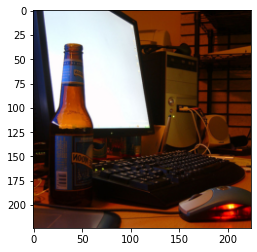

greedy:  a desk with a laptop and a monitor on it
beam:  a computer is sitting on a desk and a desk
true_cap:  a bottle of beer sits next to the keyboard and mouse at the computer table


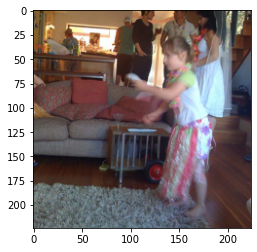

greedy:  a woman is sitting on a couch with a stuffed animal
beam:  a woman is sitting on a child ' snugg
true_cap:  a young girl playing a video game while others talk


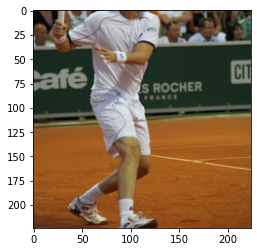

greedy:  a tennis player is getting ready to hit the ball
beam:  a man is getting ready to hit the tennis ball
true_cap:  a man playing tennis getting ready to take a swing


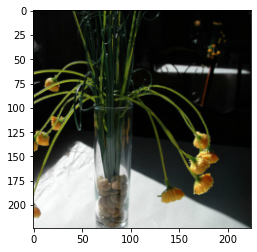

greedy:  a vase with some flowers in it
beam:  a glass vases of flowers in a glass vase
true_cap:  a glass vase with some flower coming out of it


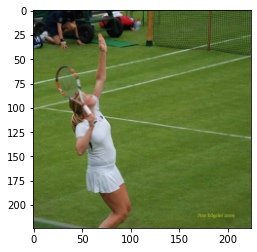

greedy:  a woman is holding a tennis racket in her hand
beam:  a woman is playing tennis on the court
true_cap:  a woman holding a tennis racket in her hand


In [17]:
random_test(5)